# Titanic Project: Will a Passenger Survive?
Group 33 Members: Chloe Vaughan, Susan Zhang, James Drover, Olivia Klassen, and Adeeb Khan

## Introduction

In 1912, the RMS Titanic sank 5 days into her first trip across the Atlantic Ocean. Originally dubbed "unsinkable", the ship is one of the most famous tragedies in modern history. Whether a passenger survived was not entirely luck-based, some passengers were more likely to survive than others. In this project, we examine what passengers are most likely to survive, then finally build a classification model to predict the survival status of people onboard. This analysis allows better understanding of the political environment during the which the Titanic sank. It is important to present and analyze this data so that we can think about how we might prioritize lives if a similar event were to occur. How was the lifeboat distribution prioritzied, and was it fair? Would we do things differently now, seeing as we have evolved towards equity as a society?  

[The Titanic dataset](https://www.kaggle.com/competitions/titanic/data?select=train.csv) was obtained by Kaggle. 

**Question**: Will a given passenger survive the titanic crash? To answer this question, we must first ask what variables are important to determining survival?

**Our Variables**:
- PassengerId = **NOTE**: confused about this column, ALSO some variables from this list are later removed
- Survived = whether the passenger lived or died on the Titanic, 0 = did not survive, 1 = survived
- Passenger_Class = Indicates socio-economic status, 1 = Upper, 2 = Middle, 3 = Lower
- Name = name of passenger
- Age = age in years
- Number0fSiblings = # of siblings/spouses on the titanic
- NumberofParents_children = # of parents/children on the titanic 
- Ticket = ticket number
- Fare = passenger fare
- Cabin = cabin number
- Embarked = Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

The column names given above are not the same as the untidy data. We have renamed the columns in the original dataset. Familial relationships defined as follows:
- Sibling = brother, sister, stepbrother, stepsister, Spouse = husband, wife, note that mistresses and fiancés were ignored
- Parent = mother, father, some children travelled with a nanny, NumberofParents_children = 0 in this case. Child = daughter, son, stepdaughter, stepson

## Methods

The Titanic dataset will be cleaned and wrangled into a tidy format, in which the following variables will be omitted: passenger ID, name, embarked, ticket. These variables likely have no effect on classification as they are all titles with little bearing on real world events. Cabin number was omitted due to an overwhelming number of NA values. As well, all rows within this new set that have N/A as a value will be removed, and labels renamed to be human readable.

Survival, Class, Sex, Age, Number of Siblings on the Ship, Number of Parents/Children on the Ship, and fare will be used as variables for analysis. We will visualize the data using different types of visualizations to determine the impact of each on survival. Those with negligible impact on survival may be omitted from the prediction recipe, then the data will be trained to predict if a given passenger will survive.

### Installing Packages & Libraries

In [16]:
install.packages('themis')
install.packages('psych')
install.packages('gridExtra')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [17]:
library(themis)
library(tidyverse)
library(tidymodels)
library(dplyr)
library(psych)
library(gridExtra)

## Preliminary Data Analysis

Our first data anlysis step is to examine the data. Before we build our model, we need to read the data into R, then rename the columns with more intuitive names. Our next step is to become familiar with some statics on our data (e.g. number of observations, what each column means, can columns be dropped at this step, etc). We also need to wrangle our data into a tidy format. Some variables are changed to another class, and we examine how many NA values are present in our data. Tidy data ensures that the functions we employ later on work seamlessly, and makes the data easier to interpret.

In [18]:
boat_data <- read_csv("data/train.csv")
colnames(boat_data) = c("PassengerId", "Survived", "Passenger_Class", "Name", "Sex", "Age", "Number0fSiblings", 
                                 "NumberofParents_children", "Ticket", "Fare", "Cabin", "Embarked")
head(boat_data)

Rows: 891 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Name, Sex, Ticket, Cabin, Embarked
dbl (7): PassengerId, Survived, Pclass, Age, SibSp, Parch, Fare

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


PassengerId,Survived,Passenger_Class,Name,Sex,Age,Number0fSiblings,NumberofParents_children,Ticket,Fare,Cabin,Embarked
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NA,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NA,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NA,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,NA,Q


Rarely are all the variables used to build a model, inclusion of too many can negatively impact our model's accuracy. Variables are excluded for several reasons: 

- 1) they may be a poor predictor of our target variable survival status 
- 2) too many NA values may be present and we have little data to work with 
- 3) the data collected is irrelevant, e.g. name, or enumeration of each entry in the data set

We visualize the relationship between predictors and survival status in the exploratory data analysis step. In the preliminary stage, we only drop variables based on criteria 2) and 3). Using the describe function from the psych package, we can get detailed summary statistics for each column (Table 1). 

In [19]:
nrow(boat_data)

[1] 891

In [20]:
describe(boat_data)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PassengerId,1,891,446.0000000,257.3538420,446.0000,446.0000000,330.61980,1.00,891.0000,890.0000,0.000000e+00,-1.2040412,8.62167810
Survived,2,891,0.3838384,0.4865925,0.0000,0.3548387,0.00000,0.00,1.0000,1.0000,4.769135e-01,-1.7745414,0.01630146
Passenger_Class,3,891,2.3086420,0.8360712,3.0000,2.3856942,0.00000,1.00,3.0000,2.0000,-6.284264e-01,-1.2834293,0.02800944
Name*,4,891,446.0000000,257.3538420,446.0000,446.0000000,330.61980,1.00,891.0000,890.0000,0.000000e+00,-1.2040412,8.62167810
Sex*,5,891,1.6475870,0.4779901,2.0000,1.6844320,0.00000,1.00,2.0000,1.0000,-6.168385e-01,-1.6213262,0.01601327
Age,6,714,29.6991176,14.5264973,28.0000,29.2692308,13.34340,0.42,80.0000,79.5800,3.874744e-01,0.1597671,0.54364050
Number0fSiblings,7,891,0.5230079,1.1027434,0.0000,0.2720898,0.00000,0.00,8.0000,8.0000,3.682919e+00,17.7269083,0.03694329
NumberofParents_children,8,891,0.3815937,0.8060572,0.0000,0.1823282,0.00000,0.00,6.0000,6.0000,2.739868e+00,9.6880847,0.02700393
Ticket*,9,891,339.5173962,200.8342670,338.0000,339.6465638,268.35060,1.00,681.0000,680.0000,5.569478e-05,-1.2817773,6.72820110


**Table 1.** Summary Statistics for all Columns in Dataset

Two variables under the count (n) column catch our eye; both Age and Cabin have quite a few NA values. We have decided to remove "Cabin" as a predictor because only 204 out of 891 observations (23%) are not NA (Table 1). In contrast, 714 out of 891 columns do have a value assigned for age, thus we keep this predictor as non-NA values constitute 80% of the total data. 

We also decided to drop Name, Ticket, and PassengerId as these variables contain information that is not relevant to our predictions. The Name, Ticket and passengerId are arbitrary, they do not hold information that will have a big impact. Below we remove the irrelevant predictors. 

In [56]:
#getting rid of PassengerId,Name, Embarked,Ticket and Cabin:
boat_data_selected <- boat_data |>
    select(-PassengerId,-Name, -Ticket, -Cabin)

Two additional columns are added, one to turn sex into binary (1 = male, 0 = female), and another that converts the port of embarkation into numerical values (0 = Southampton, 1 = Cherbourg, 2 = Queenstown). We also remove NA values from age, and convert survived into a factor. The data type of each column is important to ensure all functions work seamlessly.

In [129]:
#adding a column for sex in binary and making the embarked column into numeric(for it to work with the knn model)

boat_data_binary <- boat_data_selected |>
    mutate(sex_binary = ifelse(Sex == "male", 1, ifelse(Sex == "female", 0, NA))) |>
    mutate(Embarked_numeric = ifelse(Embarked == "S", 0, ifelse(Embarked == "C", 1, ifelse(Embarked == "Q", 2, NA))))

boat_data_NA <- boat_data_binary |>
    filter(!is.na(Age)) |>
    mutate(Survived = as_factor(Survived))
head(boat_data_NA)

Survived,Passenger_Class,Sex,Age,Number0fSiblings,NumberofParents_children,Fare,Embarked,sex_binary,Embarked_numeric
<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
0,3,male,22,1,0,7.2500,S,1,0
1,1,female,38,1,0,71.2833,C,0,1
1,3,female,26,0,0,7.9250,S,0,0
1,1,female,35,1,0,53.1000,S,0,0
0,3,male,35,0,0,8.0500,S,1,0
0,1,male,54,0,0,51.8625,S,1,0


## Exploratory Data Analysis

Before we begin exploratory data analysis, our data set has to be split. If we use testing data to build our model, we will not get a good evaluation of our model's accuracy. It already has "experience" with data like this, thus we split our data into two sets; 70% to train our model, 30% to test it on.

In [58]:
set.seed(911)
#splitting the wrangled data into test and training sets
#we chose a 70-30 percent split to ensure our model is accurate at the same time as making sure the testing is accurate.

boat_split <- initial_split(boat_data_NA, prop = 0.7, strata = Survived)
boat_train <- training(boat_split)
boat_test <- testing(boat_split)

As of now, we have 7 possible predictors to determine "survived": Passenger_class, Sex, Age, Number0fSiblings, NumberofParents_children, Fare, and Embarked. First, we want a grasp of overall survival rate. Table 2 shows that more people died than the number who lived. 

In [73]:
summary_table_survived <- boat_train |> group_by(Survived) |> 
    summarize(Count = n())

summary_table_survived

Survived,Count
<fct>,<int>
0,296
1,203


**Table 2.** Number of passengers who died (0) versus survived (1). 

Another variable we want to explore straight from the get-go is Sex. It is commonly thought that more women survived then men. We confirm this observation in Figure 1. 

Warning message:
“Removed 10 rows containing missing values (geom_bar).”
Warning message:
“Removed 10 rows containing missing values (geom_bar).”
Warning message:
“Removed 8 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing non-finite values (stat_bin).”


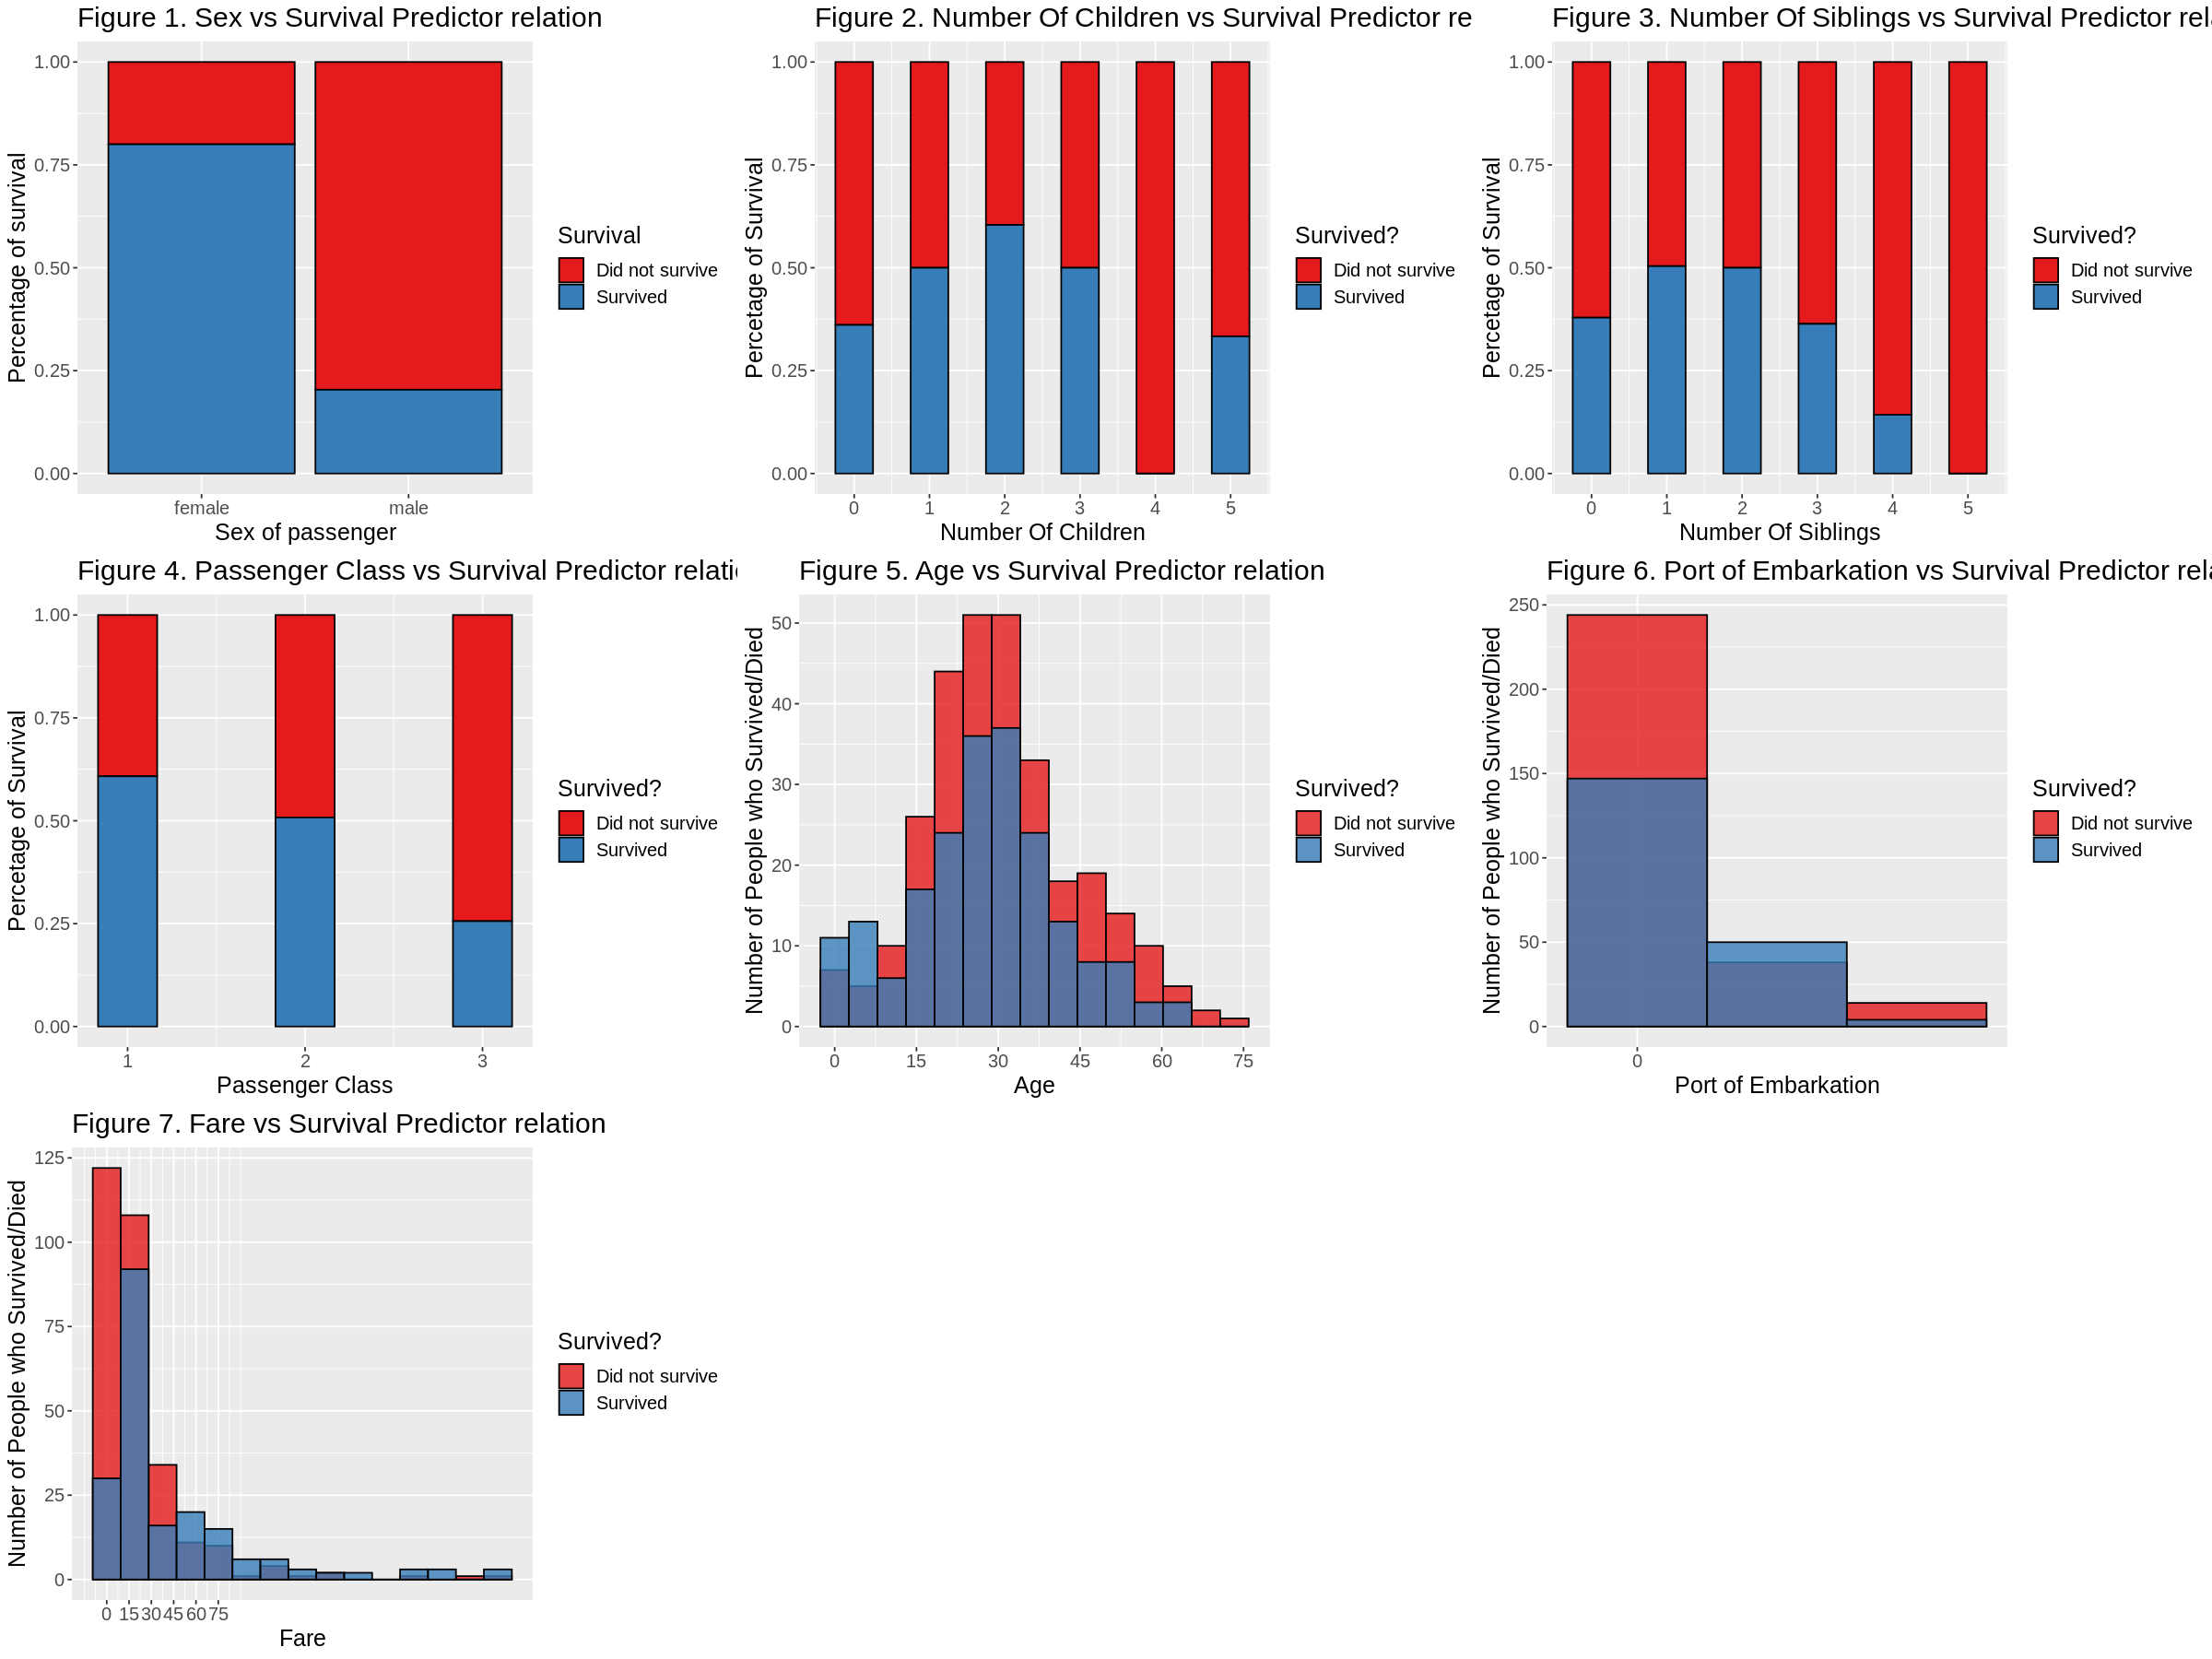

In [130]:
temp_data_graph <- boat_train |>
    mutate(Survived_char = ifelse(Survived == 1, "Survived", ifelse(Survived == 0, "Did not survive", NA)))

survival_bar_plot_sex <- ggplot(temp_data_graph, aes(x = Sex, fill = as_factor(Survived_char))) +
    geom_bar(position = "fill", col = "black") +
    labs(x = "Sex of passenger", y = "Percentage of survival", fill = "Survival") +
    ggtitle("Figure 1. Sex vs Survival Predictor relation") +
    scale_fill_brewer(palette = "Set1") + 
    theme(text=element_text(size=15)) #Fare not yet explored

NOC_survival <- temp_data_graph |>
    ggplot(aes(x = NumberofParents_children, fill = as_factor(Survived_char))) +
    geom_histogram(bins = 11, position = "fill", col = "black") +
    labs(x = "Number Of Children", y = "Percetage of Survival", fill = "Survived?") + 
    scale_x_continuous(breaks = c(0, 1, 2,3,4,5)) +
    ggtitle("Figure 2. Number Of Children vs Survival Predictor relation") +
    scale_fill_brewer(palette = "Set1") + 
    theme(text=element_text(size = 15))

NOS_survival <- temp_data_graph |>
    ggplot(aes(x = Number0fSiblings, fill = as_factor(Survived_char))) +
    geom_histogram(bins = 11, position = "fill", col = "black") +
    labs(x = "Number Of Siblings", y = "Percetage of Survival", fill = "Survived?") + 
    scale_x_continuous(breaks = c(0, 1, 2,3,4,5)) +
    ggtitle("Figure 3. Number Of Siblings vs Survival Predictor relation") +
    scale_fill_brewer(palette = "Set1") +
    theme(text=element_text(size = 15))

class_survival <- temp_data_graph |>
    ggplot(aes(x = Passenger_Class, fill = as_factor(Survived_char))) +
    geom_histogram(bins = 7, position = "fill", col = "black") +
    labs(x = "Passenger Class", y = "Percetage of Survival", fill = "Survived?") + 
    scale_x_continuous(breaks = c(0, 1, 2,3)) +
    ggtitle("Figure 4. Passenger Class vs Survival Predictor relation") +
    scale_fill_brewer(palette = "Set1") + 
    theme(text=element_text(size = 15))

AgevSurvived <- temp_data_graph |>
    ggplot(aes(x = Age, fill = as_factor(Survived_char))) +
    geom_histogram(bins = 15, position = "identity", alpha = 0.8, col = "black") +
    labs(x = "Age", y = "Number of People who Survived/Died", fill = "Survived?")+
    scale_x_continuous(breaks = seq(from = 0, to = 80, by = 15)) + 
    ggtitle("Figure 5. Age vs Survival Predictor relation") +
    scale_fill_brewer(palette = "Set1") +  
    theme(text=element_text(size = 15))

EmbarkedvSurvived <- temp_data_graph |>
    ggplot(aes(x = Embarked_numeric, fill = as_factor(Survived_char))) +
    geom_histogram(bins = 3, position = "identity", alpha = 0.8, col = "black") +
    labs(x = "Port of Embarkation", y = "Number of People who Survived/Died", fill = "Survived?")+
    scale_x_continuous(breaks = seq(from = 0, to = 80, by = 15)) + 
    ggtitle("Figure 6. Port of Embarkation vs Survival Predictor relation") +
    scale_fill_brewer(palette = "Set1") +  
    theme(text=element_text(size = 15))

FarevSurvived <- temp_data_graph |> filter(Fare <275) |>
    ggplot(aes(x = Fare, fill = as_factor(Survived_char))) +
    geom_histogram(bins = 15, position = "identity", alpha = 0.8, col = "black") +
    labs(x = "Fare", y = "Number of People who Survived/Died", fill = "Survived?")+
    scale_x_continuous(breaks = seq(from = 0, to = 80, by = 15)) + 
    ggtitle("Figure 7. Fare vs Survival Predictor relation") +
    scale_fill_brewer(palette = "Set1") +  
    theme(text=element_text(size = 15))

options(repr.plot.width = 20, repr.plot.height = 15)
grid.arrange(survival_bar_plot_sex, NOC_survival, NOS_survival, class_survival, AgevSurvived, EmbarkedvSurvived, FarevSurvived)

In [34]:
#summary table for how many men and women are there in the training data.
summary_table_sex <- boat_train |>
    group_by(Sex) |>
    summarize(Number_of_passengers = n())
summary_table_sex

Sex,Number_of_passengers
<chr>,<int>
female,170
male,329


In [132]:
#Adding summary table for age (years) for training data
summary_table_age <- boat_train |>
    summarize(mean_age = mean(Age))
summary_table_age

#adding a summary table for the number of passengers in each class for training data:
summary_table_class <- boat_train |>
    group_by(Passenger_Class) |>
    summarize(Number_of_passengers = n())
summary_table_class

#Adding summary table for number of children for training data
summary_table_children <- boat_train |>
    summarize(mean_children = mean(NumberofParents_children))
summary_table_children

mean_age
<dbl>
29.34435


Passenger_Class,Number_of_passengers
<dbl>,<int>
1,125
2,124
3,250


mean_children
<dbl>
0.4268537


Distribution of Data

In [ ]:
age_vis <- boat_train |>
    ggplot(aes(x = Age)) +
    geom_histogram(binwidth = 6, fill = "deepskyblue2", col = "black") + 
    ggtitle("Figure. Age Distribution") + 
    theme(text=element_text(size=16)) 
age_vis

noc_vis <- boat_train |>
    ggplot(aes(x = NumberofParents_children)) +
    geom_histogram(binwidth = 1, fill = "deepskyblue2", col = "black") +
    ggtitle("Figure. Distribution of Parent per Child Ratio") +
    theme(text=element_text(size=16)) 

noc_vis

## Predictor Variable Selection

In [36]:
set.seed(911)

boat_train_model <- boat_train |>
    select(-Sex)
#Now we start the process of developing a model to predict weather a given passenger survived the titanic crash.

boat_spec_tune <- knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

boat_vfold <- vfold_cv(boat_train_model, v = 10, strata = Survived)
k_vals <- tibble(neighbors = seq(from = 1, to = 35, by = 2))


In [59]:
set.seed(911)

names <- c("Passenger_Class", "Age", "Number0fSiblings", "NumberofParents_children", "Fare","sex_binary","Embarked_numeric")

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())


# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Survived", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        boat_recipe <- recipe(as.formula(model_string), 
                                data = boat_train_model) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(boat_recipe) |>
          add_model(boat_spec_tune) |>
          tune_grid(resamples = boat_vfold, grid = k_vals) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

x Fold01: preprocessor 1/1, model 1/1 (predictions):
  Error in `mutate()`:
  ! Problem while computing `.row = orig_rows`.
  ✖ `.row` must be size 50 or 1, not 51.

x Fold10: preprocessor 1/1, model 1/1 (predictions):
  Error in `mutate()`:
  ! Problem while computing `.row = orig_rows`.
  ✖ `.row` must be size 48 or 1, not 49.

x Fold01: preprocessor 1/1, model 1/1 (predictions):
  Error in `mutate()`:
  ! Problem while computing `.row = orig_rows`.
  ✖ `.row` must be size 50 or 1, not 51.

x Fold10: preprocessor 1/1, model 1/1 (predictions):
  Error in `mutate()`:
  ! Problem while computing `.row = orig_rows`.
  ✖ `.row` must be size 48 or 1, not 49.

x Fold01: preprocessor 1/1, model 1/1 (predictions):
  Error in `mutate()`:
  ! Problem while computing `.row = orig_rows`.
  ✖ `.row` must be size 50 or 1, not 51.

x Fold10: preprocessor 1/1, model 1/1 (predictions):
  Error in `mutate()`:
  ! Problem while computing `.row = orig_rows`.
  ✖ `.row` must be size 48 or 1, not 49.

x Fo

size,model_string,accuracy
<int>,<chr>,<dbl>
1,Survived ~ Fare,0.6778824
2,Survived ~ Fare+sex_binary,0.7955454
3,Survived ~ Fare+sex_binary+Passenger_Class,0.8136695
4,Survived ~ Fare+sex_binary+Passenger_Class+Age,0.8141905
5,Survived ~ Fare+sex_binary+Passenger_Class+Age+Number0fSiblings,0.8180320
6,Survived ~ Fare+sex_binary+Passenger_Class+Age+Number0fSiblings+NumberofParents_children,0.8259552
7,Survived ~ Fare+sex_binary+Passenger_Class+Age+Number0fSiblings+NumberofParents_children+Embarked_numeric,0.8123029


In [84]:
#here we begin analysing the perdictors CODE PASTED ABOVE
#bar graph to display how many people survived vs how many did not.(percentage of survival)

## Creating Initial Classification Engine & Finding the Best K Value

In [44]:
#tuning the model to find the best value of k using the best predictors as seen above.

boat_recipe <- recipe(Survived ~ Fare +sex_binary + Passenger_Class + Age + Number0fSiblings, data = boat_train_model) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

boat_model_stats <- workflow() |>
  add_recipe(boat_recipe) |>
  add_model(boat_spec_tune) |>
  tune_grid(resamples = boat_vfold, grid = k_vals) |>
  collect_metrics() |>
  filter(.metric == "accuracy")

boat_model_stats
    

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7478904,10,0.01671011,Preprocessor1_Model01
3,accuracy,binary,0.8041072,10,0.01508574,Preprocessor1_Model02
5,accuracy,binary,0.8180320,10,0.01401168,Preprocessor1_Model03
7,accuracy,binary,0.8138687,10,0.01378287,Preprocessor1_Model04
9,accuracy,binary,0.8179504,10,0.01308060,Preprocessor1_Model05
11,accuracy,binary,0.8159112,10,0.01258703,Preprocessor1_Model06
13,accuracy,binary,0.8078295,10,0.01284384,Preprocessor1_Model07
15,accuracy,binary,0.8076695,10,0.01299153,Preprocessor1_Model08
17,accuracy,binary,0.8017055,10,0.01461988,Preprocessor1_Model09


<ScaleContinuousPosition>
 Range:  
 Limits:  0.4 --    1

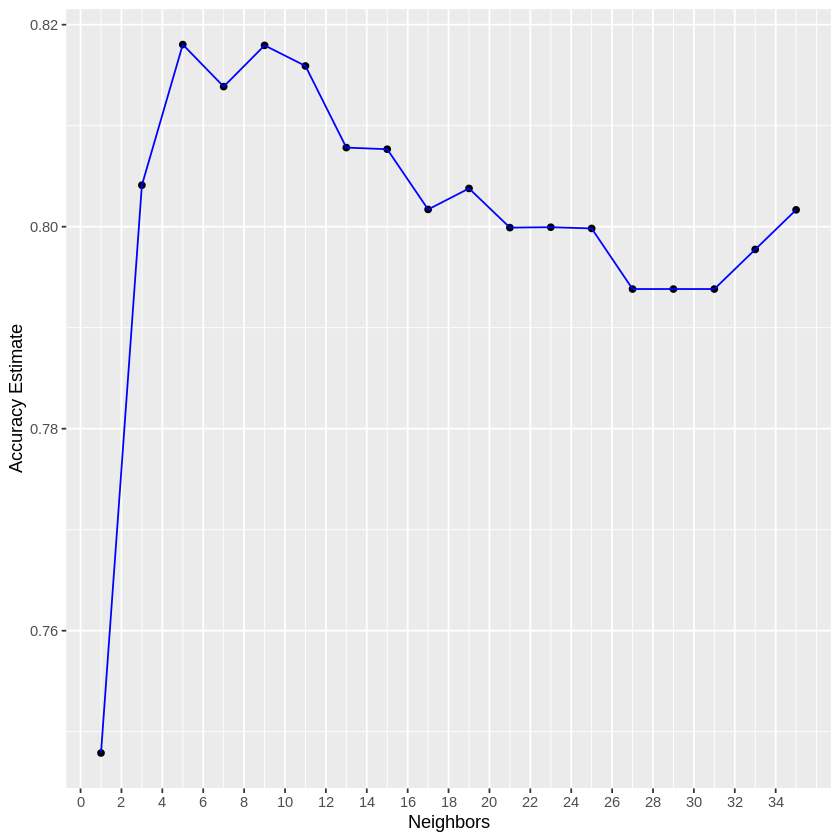

In [45]:
accuracy_versus_k <- ggplot(boat_model_stats, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line(color = "blue") +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 35, by = 2))
       scale_y_continuous(limits = c(0.4, 1.0))

accuracy_versus_k

## Creating Final Model

In [46]:
set.seed(911)
#pulling the max value of k and retraining the model with given k:

kmax <- boat_model_stats|>
    filter(mean == max(mean)) |>
    pull(neighbors)

boat_spec <- knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmax) |>
  set_engine("kknn") |>
  set_mode("classification")

boat_fit <- workflow() |>
  add_recipe(boat_recipe) |>
  add_model(boat_spec) |>
  fit(data = boat_train_model)

kmax

[1] 5

In [47]:
set.seed(911)
#testing the model's accuracy on testing data:

accuracy_estimate <- predict(boat_fit, boat_test) |>
    bind_cols(boat_test) |>
    metrics(truth = Survived, estimate = .pred_class) |>
    filter(.metric == "accuracy")

accuracy_estimate

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8046512


In [48]:
#finding the majority class prediction:

majority_class <- boat_test |>
    group_by(Survived) |>
    summarise(count = n(), percentage = n()/nrow(boat_test))

majority_class

Survived,count,percentage
<fct>,<int>,<dbl>
0,128,0.5953488
1,87,0.4046512


In [49]:
predictions <- predict(boat_fit, boat_test) |>
    bind_cols(boat_test)

analysis1 <- predictions |>
    group_by(.pred_class, Survived) |>
    summarise(count = n()) |>
    ungroup() |> 
    mutate(percent = count/sum(count))

analysis1


`summarise()` has grouped output by '.pred_class'. You can override using the
`.groups` argument.


.pred_class,Survived,count,percent
<fct>,<fct>,<int>,<dbl>
0,0,106,0.49302326
0,1,20,0.09302326
1,0,22,0.10232558
1,1,67,0.31162791


          Truth
Prediction   0   1
         0 106  20
         1  22  67

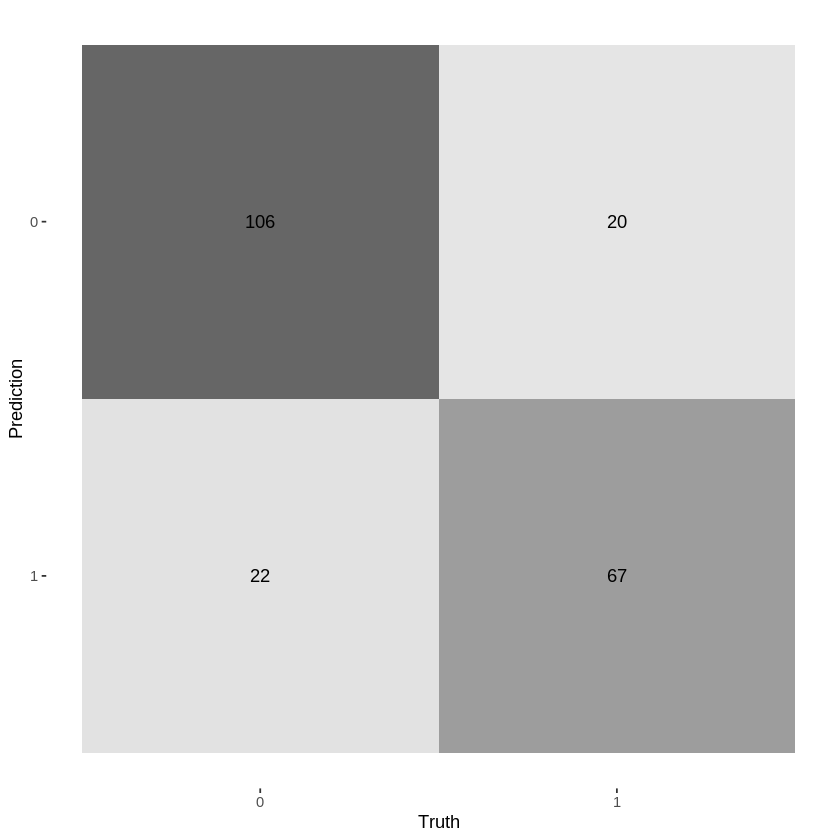

In [50]:
confusion_matrix <- predictions |>
    conf_mat(truth = Survived, estimate = .pred_class)

confusion_matrix

autoplot(confusion_matrix,type = "heatmap", Truth ="")

In [51]:
analysis2 <- predict(boat_fit, boat_test) |>
    bind_cols(boat_test) |>
    filter(Survived != .pred_class) |>
    group_by(Passenger_Class, Survived)	|>
    summarise(count = n())
percent_of_pop <- boat_test |>
    group_by(Passenger_Class) |>
    summarise(count = n()) |>
    ungroup() |> 
    mutate(percent = count/sum(count))
    
analysis2

percent_of_pop

`summarise()` has grouped output by 'Passenger_Class'. You can override using
the `.groups` argument.


Passenger_Class,Survived,count
<dbl>,<fct>,<int>
1,0,4
1,1,10
2,0,1
2,1,2
3,0,17
3,1,8


Passenger_Class,count,percent
<dbl>,<int>,<dbl>
1,61,0.2837209
2,49,0.2279070
3,105,0.4883721


In [52]:
#slighly more accurate for males due to more males being in the training set

predictions %>%
group_by(sex_binary, Survived == .pred_class) %>%
summarize(count = n()) %>%
mutate(prop = count/sum(count))


`summarise()` has grouped output by 'sex_binary'. You can override using the
`.groups` argument.


sex_binary,Survived == .pred_class,count,prop
<dbl>,<lgl>,<int>,<dbl>
0,FALSE,20,0.2197802
0,TRUE,71,0.7802198
1,FALSE,22,0.1774194
1,TRUE,102,0.8225806


In [53]:
#very accurate for second class why??

predictions %>%
group_by(Passenger_Class, Survived == .pred_class) %>%
summarize(count = n()) %>%
mutate(prop = count/sum(count))

`summarise()` has grouped output by 'Passenger_Class'. You can override using
the `.groups` argument.


Passenger_Class,Survived == .pred_class,count,prop
<dbl>,<lgl>,<int>,<dbl>
1,FALSE,14,0.22950820
1,TRUE,47,0.77049180
2,FALSE,3,0.06122449
2,TRUE,46,0.93877551
3,FALSE,25,0.23809524
3,TRUE,80,0.76190476


In [54]:
predictions %>%
group_by(Number0fSiblings, Survived == .pred_class) %>%
summarize(count = n()) %>%
mutate(prop = count/sum(count))

`summarise()` has grouped output by 'Number0fSiblings'. You can override using
the `.groups` argument.


Number0fSiblings,Survived == .pred_class,count,prop
<dbl>,<lgl>,<int>,<dbl>
0,FALSE,24,0.1702128
0,TRUE,117,0.8297872
1,FALSE,15,0.2586207
1,TRUE,43,0.7413793
2,FALSE,2,0.2857143
2,TRUE,5,0.7142857
3,TRUE,1,1.0000000
4,FALSE,1,0.2500000
4,TRUE,3,0.7500000


## Final Analysis of our Model

## Discussion

## References